# Atividade 1

## Análise do dataset de clientes

Durante a disciplina, o professor demonstrou a utilização do software __[Weka](https://www.cs.waikato.ac.nz/ml/weka/)__, para implementação do algoritmo [K-means](https://pt.wikipedia.org/wiki/K-means).

Para isso criei um script neste repositório, chamado [_generate.py_](./generate.py), que tem a função de criar um dataset com [dados sintéticos](https://blog.nvidia.com.br/2021/07/20/o-que-sao-dados-sinteticos/) para as análises.

Nestes meus testes utilizarei o [python](https://pt.wikipedia.org/wiki/Python) através de um [notebook](https://pt.wikipedia.org/wiki/Projeto_Jupyter).

O original deste notebook pode ser acessado [neste link](https://github.com/adrianowead/unicid-ds-alg-03-23), assim como o dataset utilizado e demais arquivos da tarefa.

Este dataset sintético nos permite alguns tipos de análise, o que faremos aqui é relacionar as comunicações de marketing enviadas aos clientes no último mês (não necessariamente lidas por eles), e quantos produtos eles compraram.

O dataset também inclui informações de __idade__ e __genero__, precisamos entender quais atributos possuem relação com a quantidade de produtos comprados por cada um.


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mlxtend.frequent_patterns import apriori, association_rules

In [92]:
df = pd.read_csv('dados_sinteticos.csv')

Abaixo é exibido o início do dataset, para visualizar como estão dispostos os dados neste momento.

In [93]:
df.head()

,idade,genero,estado_civil,email,sms,mala_direta,produtos_comprados
0,56,M,Divorciado,3,1,1,3
1,69,M,Solteiro,1,1,5,2
2,46,F,Divorciado,1,1,0,1
3,32,M,Solteiro,1,1,1,1
4,60,M,Divorciado,0,1,1,1


### Preparação

O k-means utiliza dados numéricos para calcular o posicionamento dos crentróides, bem como a classificação das demais instâncias, e neste experimento estamos utilizando a [distância euclidiana](https://pt.wikipedia.org/wiki/Dist%C3%A2ncia_euclidiana), que é o valor padrão.

Assim sendo, precisamos provisoriamente remover as colunas não numéricas do dataset.

In [94]:
# criando uma cópia do dataset com apenas as colunas numéricas
dfk = df.select_dtypes([np.number])

# normalizando os dados
dfk_norm = (dfk - dfk.mean()) / dfk.std()

dfk_norm.head()

,idade,email,sms,mala_direta,produtos_comprados
0,0.339125,0.767251,0.021414,-0.462364,0.387357
1,1.056791,-0.412228,0.021414,1.964745,-0.123668
2,-0.212926,-0.412228,0.021414,-1.069142,-0.634693
3,-0.985798,-0.412228,0.021414,-0.462364,-0.634693
4,0.559945,-1.001968,0.021414,-0.462364,-0.634693


In [95]:
# parâmetros de inicialização do k-means
kmeans_kwargs = {
  'init': 'random',
  'max_iter': 500,
  'random_state': 10,
  'tol': 1.0e-1,
  'n_init': 100
}

max_clusters = 50

# criando a listra de RMS para armazenar os resultados de cada k clsuter
rms = []

# esse loop reproduz o efeito de rodar várias vezes com quantidade de clusters diferentes
# extamente como o professor orientou, iniciar com 1 cluster e ir aumentando
# com o objetivo de observar o 'joelho' do gráfico
for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dfk_norm)
    
    train_pred = kmeans.predict(dfk_norm)
    rms.append(mean_squared_error(dfk_norm, kmeans.cluster_centers_[train_pred]))

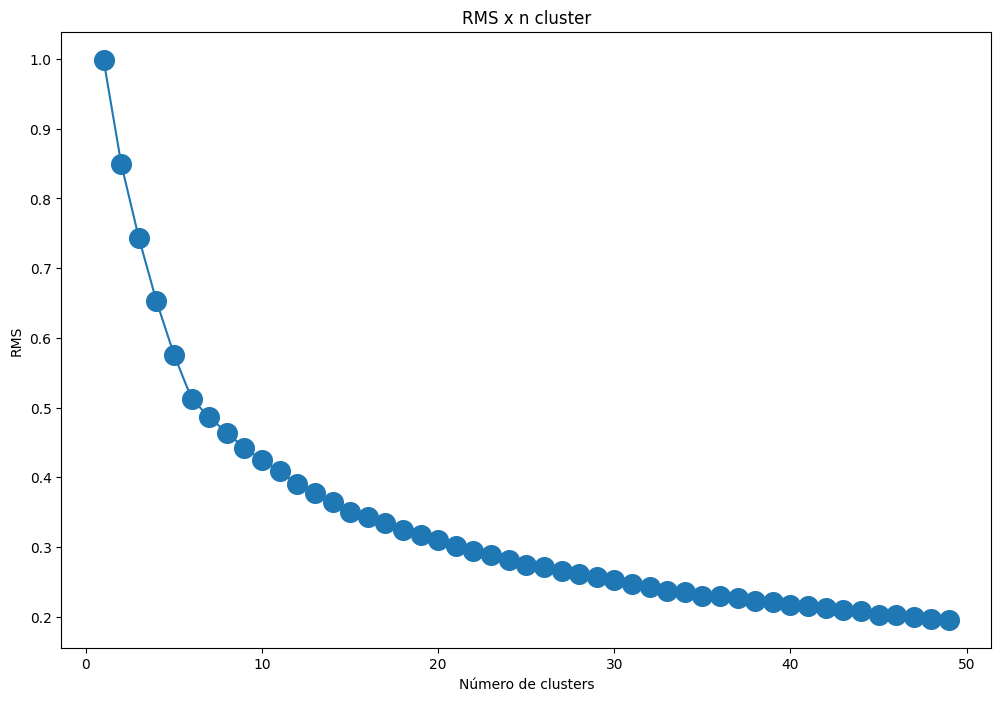

In [96]:
# plotando a curva de inércia (RMS)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(range(1, max_clusters), rms, s=200)
ax.plot(range(1, max_clusters), rms)
ax.set_xlabel('Número de clusters')
ax.set_ylabel('RMS')
ax.set_title('RMS x n cluster')
plt.show()

### Ponto de parada

Verificamos que o momento onde o gráfico forma o 'joelho' é onde seria o ponto ideal, com a quantidade de clusters suficientes para treinar sem overfit.

Mas existira uma forma melhor de medir isso, sem ir no 'olhômetro'?

A resposta é sim!

Hoje, dia 17/03/2022 ocorreu às 08h30 uma web conferência temática, com a presença do Profº José Almir, e o Profº Alexandre M. Lucena

Nesta web aula foi apresentado o método de validação cruzada, que aumenta a acurácia do modelo, mas também foi apresentada a técnica de split, que consiste em separar uma parte do dataset para validação do modelo.

Em resumo, o modelo é treinado e validado ao mesmo tempo, com a mesma quantidade de clusters, o objetivo é que o erro apresentado com os dados de validação nunca fiquem abaixo do erro de treinamento.

Quando isso acontece significa que o modelo não é mais capaz de generalizar, tornando-se especialista nos dados de treino, o chamado __overfit__.


In [97]:
"""
Separando dados de treino e teste
utilizando % do dataset para teste
"""
tamanho_treino = 0.2
tamanho_treino = int(len(df) * tamanho_treino)

treino_dfk = df.select_dtypes([np.number])
teste_dfk = treino_dfk.tail(tamanho_treino)

treino_dfk = treino_dfk.iloc[:-tamanho_treino]

print( len(df), len(treino_dfk), len(teste_dfk) )


1000 800 200


In [98]:
# normalizando os dados
treino_dfk = (treino_dfk - treino_dfk.mean()) / treino_dfk.std()
teste_dfk = (teste_dfk - teste_dfk.mean()) / teste_dfk.std()

teste_dfk

,idade,email,sms,mala_direta,produtos_comprados
800,-1.125921,2.610014,-0.051389,1.303197,0.391636
801,-0.419333,1.388955,1.661573,1.879833,-0.666839
802,1.048197,-1.053164,-0.907870,-0.426711,0.391636
803,1.428667,1.999485,1.661573,-0.426711,-0.666839
804,-0.636745,-0.442634,0.805092,-1.003347,0.391636
...,...,...,...,...,...
995,-1.723804,-1.053164,-0.051389,0.149925,-0.137602
996,-0.799804,0.778425,-0.907870,0.726561,-1.196077
997,-0.038862,-0.442634,-0.907870,0.149925,-0.137602
998,0.776432,0.167896,-0.051389,0.149925,-0.666839


In [99]:
# criando a listra de RMS para armazenar os resultados de cada k clsuter
rms_treino = []
rms_teste = []

max_clusters = 20

# treino e teste simultâneo
for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(treino_dfk)

    train_pred = kmeans.predict(treino_dfk)
    rms_treino.append(mean_squared_error(treino_dfk, kmeans.cluster_centers_[train_pred]))

    teste_pred = kmeans.predict(teste_dfk)
    rms_teste.append(mean_squared_error(teste_dfk, kmeans.cluster_centers_[teste_pred]))

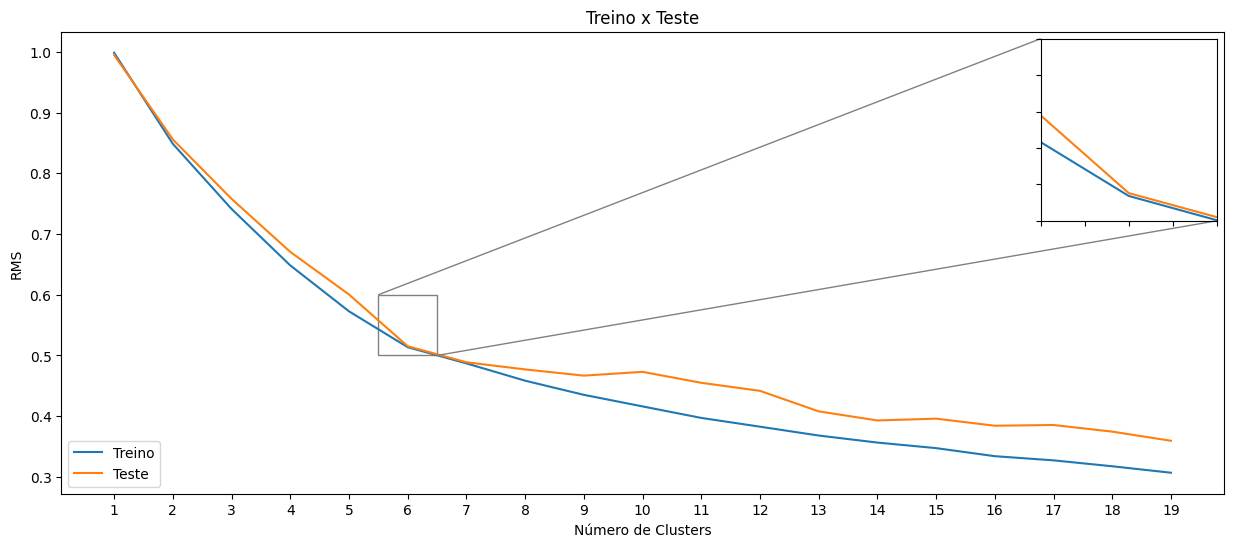

In [100]:
# exibindo o gráfico com os resultados

plt.figure(figsize=(15,6))

# definição de zoom no gráfico
x1 = 5.5
x2 = 6.5

y1 = 0.5
y2 = 0.6

ax = plt.axes()

ax.set_xlabel("Número de Clusters")
ax.set_ylabel("RMS")
ax.set_title("Treino x Teste")

ax.plot(range(1, max_clusters), rms_treino, label="Treino")
ax.plot(range(1, max_clusters), rms_teste, label="Teste")

ax.set_xticks(range(1, max_clusters))

# definindo o zoom no plot
axins = zoomed_inset_axes(ax, 3, loc=1) # zoom = 3

axins.plot(range(1, max_clusters), rms_treino)
axins.plot(range(1, max_clusters), rms_teste)

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

ax.legend(loc="lower left")

plt.xticks(visible=False)
plt.yticks(visible=False)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.draw()

plt.show()

Conforme observado no gráfico comparativo acima, durante todo o treino e teste as linhas andam muito próximas, aproximadamente na quantidade 6 de clusters existe um momento onde elas se tocam antes de começar a se distanciar, indicado na aula como __overfit__.

Conforme as instruções na citadas aula acima, este seria possivelmente o momento de parar e para este dataset essa quantidade de clusters seria o ótimo.

## Isso realmente está certo?

Conforme o que foi ensinado até o momento na disciplina, a análise pararia por aqui, mas ainda utilizando o que foi demonstrado na webaula, este dataset já possui a coluna de __produtos comprados__, ou seja, está sendo calculado este atributo para diminuição do erro.

Mas isso é justamente o que precisamos prever, sendo assim, os novos dados não possuem justamente esta coluna.

Os métodos estão corretos, mas certamente a coluna não deveria ser incluída.

### Finalidade

O algoritmo do k-means é de clusterização, e não de predição. O máximo que podemos fazer é ajustar o modelo k-means para não considerar essa coluna.

Se o objetivo é prever a coluna __produtos comprados__, é necessário usar um algoritmo de regressão ou classificação. Como regressão linear, regressão logística e árvores de decisão.

O que podemos fazer é analisar como a coluna __produtos comprados__ varia dentro de cada cluster, o K-means pode ser usado para esse fim. 

É necessário remover a coluna __produtos comprados__ dos dados de entrada e usar apenas as demais para ajustar o modelo K-means. Em seguida, os rótulos de cluster atribuídos a cada observação podem ser usados para analisar como a coluna __produtos comprados__ varia em cada cluster.

In [101]:
# remover a coluna produtos_comprados dos dados de entrada
X = dfk.drop(['produtos_comprados'], axis=1)

# ajustar o modelo KMeans
kmeans = KMeans(n_clusters=15, **kmeans_kwargs)
kmeans.fit(X)

# adicionar os rótulos de cluster ao conjunto de dados original
# observe que neste ponto, estamos adicionando o rótulo no dataset completo
# mas a geração deste rótulo não contou com a coluna alvo
# assim, podemos contabilizar a quantidade de clusters onde os demais atributos
# podem identificar corretamente a coluna alvo, ou seja, o fit ideal
# para que os demais dados se 'traduzam' na coluna alvo
df['cluster'] = kmeans.labels_

In [102]:
df.head()

,idade,genero,estado_civil,email,sms,mala_direta,produtos_comprados,cluster
0,56,M,Divorciado,3,1,1,3,3
1,69,M,Solteiro,1,1,5,2,10
2,46,F,Divorciado,1,1,0,1,8
3,32,M,Solteiro,1,1,1,1,2
4,60,M,Divorciado,0,1,1,1,6


In [103]:
# Agrupamento dos dados por cluster
grouped = df[['cluster','email','sms','mala_direta','produtos_comprados']].groupby(['cluster']).sum(numeric_only=False)

grouped

,email,sms,mala_direta,produtos_comprados
cluster,,,,
0,168,83,160,179
1,56,45,38,121
2,99,81,127,150
3,166,92,201,223
4,43,43,63,117
5,108,69,109,177
6,123,66,127,165
7,37,30,149,78
8,134,96,95,156


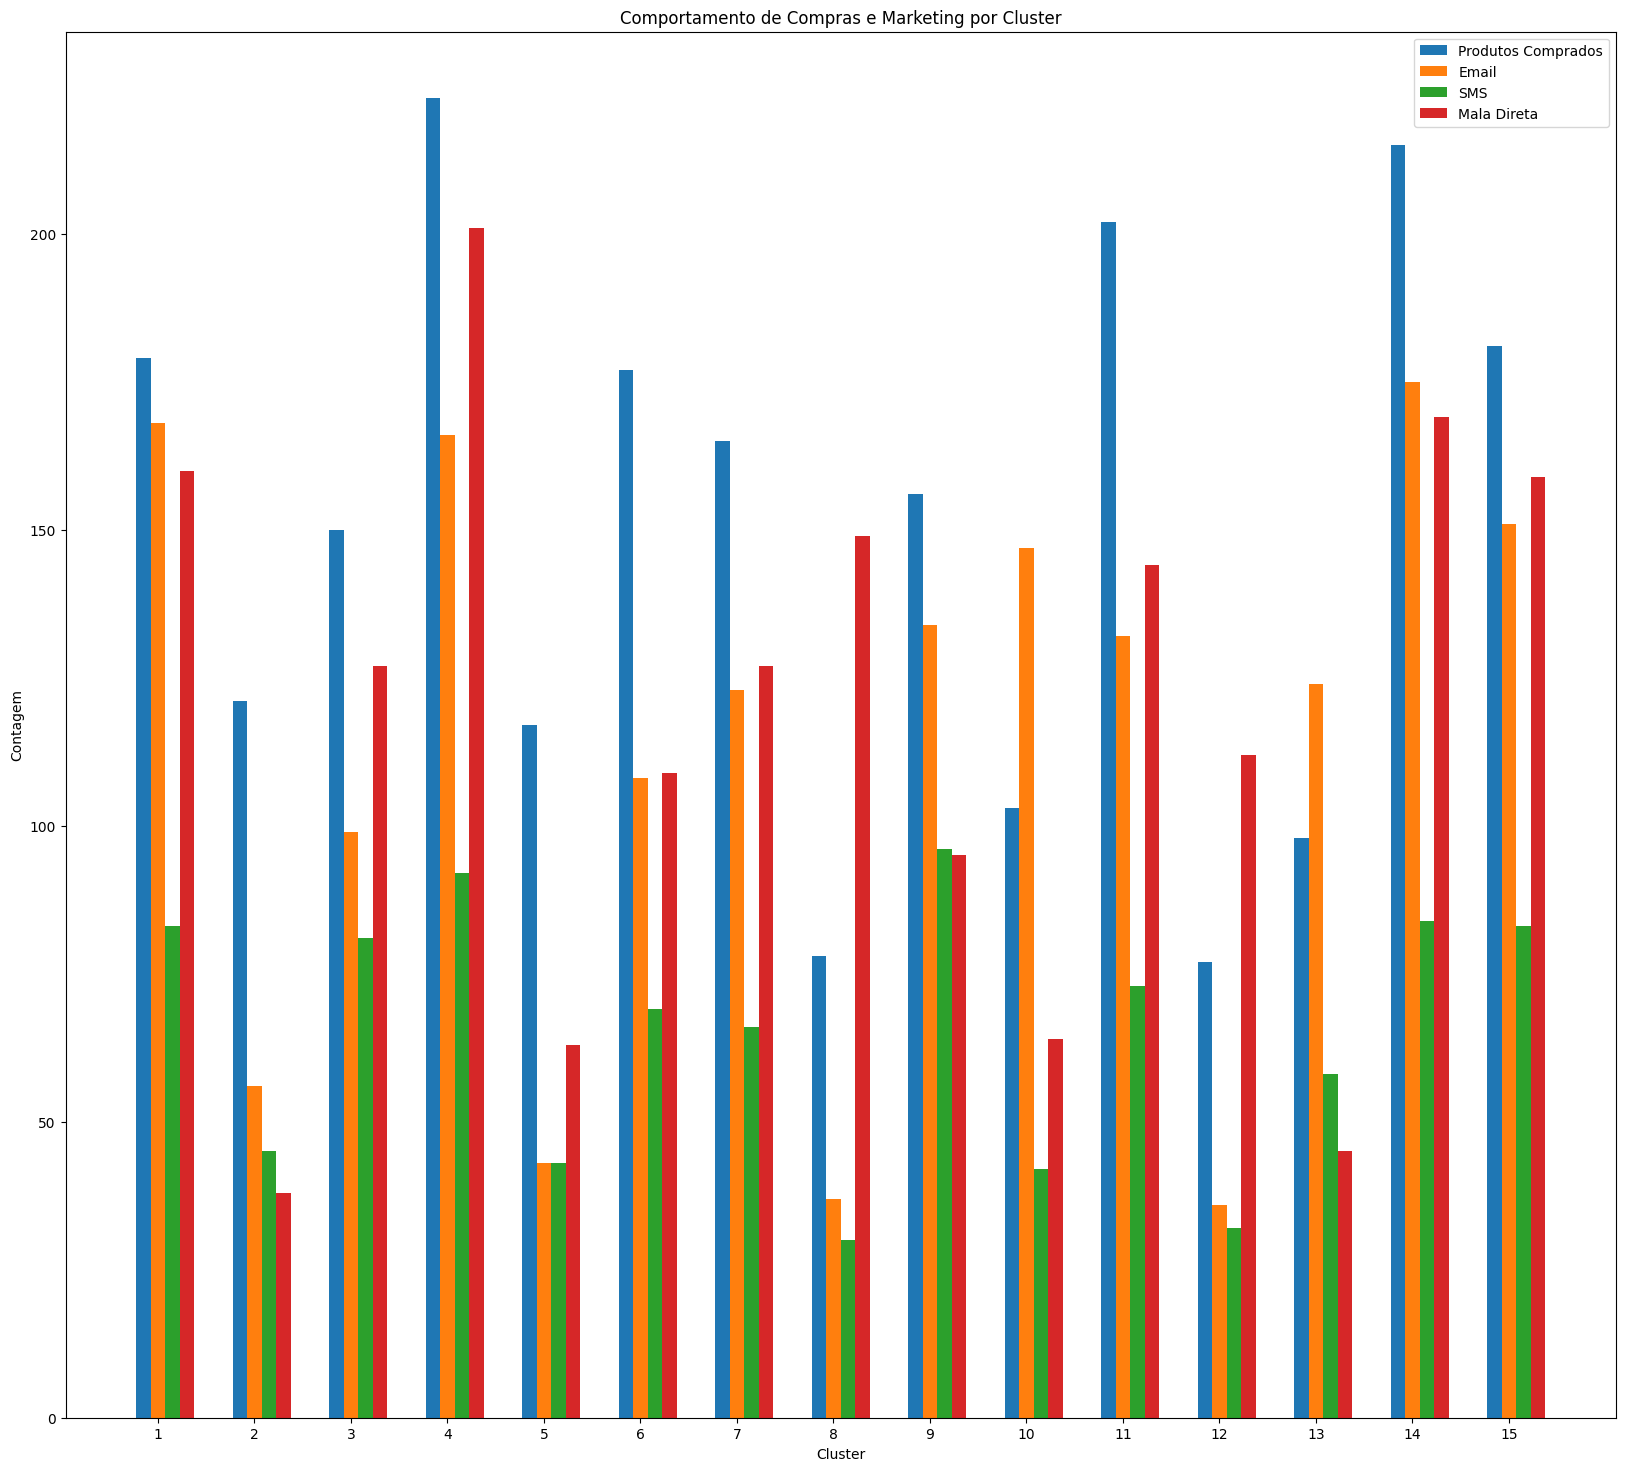

In [104]:
# Criação do gráfico de barras
fig, ax = plt.subplots(figsize=(20, 18))

x = grouped.index + 1
width = 0.15

ax.bar(x - width, grouped['produtos_comprados'], width=width, label='Produtos Comprados')
ax.bar(x, grouped['email'], width=width, label='Email')
ax.bar(x + width, grouped['sms'], width=width, label='SMS')
ax.bar(x + 2*width, grouped['mala_direta'], width=width, label='Mala Direta')

ax.set_xlabel('Cluster')
ax.set_ylabel('Contagem')
ax.set_title('Comportamento de Compras e Marketing por Cluster')
ax.set_xticks(x)
ax.legend()

plt.show()

### Conclusão sobre o K-means

Este gráfico final não deixa dúvidas, apesar da estratégia de acompanhar o treino e teste de maneira simultânea, entretando esta outra técnica de analisar a incidência da coluna alvo, que no caso eram os __produtos comprados__, ficou evidente que temos aqui duas possibilidades que são muito próximas em termos de resultados, o __cluster 4__ e o __cluster 14__.

Escolher o cluster 4 não parece ser uma boa escolha pois o RMS neste ponto ainda é alto em relação aos demais, já o 14 se mostra mais acertivo pelo baixo RMS. Apesar de neste ponto a linha de treino vs a linha de teste estarem vais afastadas em relação ao joelho no cluster 6, ainda assim apresenta um erro aceitável e com boa relação no __"teste cego"__, quando removemos a coluna alvo.

Podemos concluir que é preciso comparar diversas análises em um memso dataset, não apenas para encontrar o ponto de parada no k-means, para para a validação desta parada.

A técnica de comparar treino e teste ao mesmo tempo, nos dá um ponto final, onde não adianta mais avançar pois seria puramente desperdício de recursos, e pode levar à um provável overfit.

Identificar o joelho da curva nos dá uma boa noção de aproximadamente onde deve estar o ponto ideal, e por fim esta análise de incidências mostra exatamente onde a coluna alvo possui o melhor comportamento esperado, que no nosso caso seria o maior número de produtos comprados, previsto pelos dados treinados __SEM__ a coluna alvo.

## Algoritmo Apriori

Agora usando o mesmo dataset, só que com o algoritmo apriori, podemos utilizar as mesmas colunas já analisadas pelo k-means ou podemos procurar uma outra visão. Agora com base nos aspectos _'sociais'_ do perfil dos clientes, qual que se traduz em maior quantidade de __produtos comprados__?

In [105]:
# relendo o dataset original
df = pd.read_csv('dados_sinteticos.csv')

df

,idade,genero,estado_civil,email,sms,mala_direta,produtos_comprados
0,56,M,Divorciado,3,1,1,3
1,69,M,Solteiro,1,1,5,2
2,46,F,Divorciado,1,1,0,1
3,32,M,Solteiro,1,1,1,1
4,60,M,Divorciado,0,1,1,1
...,...,...,...,...,...,...,...
995,18,M,Viúvo,0,1,2,2
996,35,F,Divorciado,3,0,3,0
997,49,F,Solteiro,1,0,2,2
998,64,M,Viúvo,2,1,2,1


Para utilizar o algoritmo Apriori com um dataset que contenha tanto colunas categóricas quanto quantitativas, é preciso primeiro realizar a discretização dos dados, transformando as colunas quantitativas em categóricas. Isso pode ser feito utilizando a função __pd.cut()__ do pandas, que permite criar intervalos de valores para discretização.

Podemos discretizar as colunas _idade_, _email_, _sms_, _mala\_direta_ e _produtos\_comprados_.

In [106]:
df_disc = df.copy()

df_disc['idade'] = pd.cut(df['idade'], bins=[0, 18, 30, 50, 100], labels=['<18', '18-30', '30-50', '>50'])
df_disc['email'] = pd.cut(df['email'], bins=[-1, 0, 2, 5], labels=['0', '1-2', '>2'])
df_disc['sms'] = pd.cut(df['sms'], bins=[-1, 0, 2, 5], labels=['0', '1-2', '>2'])
df_disc['mala_direta'] = pd.cut(df['mala_direta'], bins=[-1, 0, 2, 5], labels=['0', '1-2', '>2'])
df_disc['produtos_comprados'] = pd.cut(df['produtos_comprados'], bins=[-1, 0, 2, 5, 10], labels=['0', '1-2', '2-5', '>10'])

df_disc

,idade,genero,estado_civil,email,sms,mala_direta,produtos_comprados
0,>50,M,Divorciado,>2,1-2,1-2,2-5
1,>50,M,Solteiro,1-2,1-2,>2,1-2
2,30-50,F,Divorciado,1-2,1-2,0,1-2
3,30-50,M,Solteiro,1-2,1-2,1-2,1-2
4,>50,M,Divorciado,0,1-2,1-2,1-2
...,...,...,...,...,...,...,...
995,<18,M,Viúvo,0,1-2,1-2,1-2
996,30-50,F,Divorciado,>2,0,>2,0
997,30-50,F,Solteiro,1-2,0,1-2,1-2
998,>50,M,Viúvo,1-2,1-2,1-2,1-2


Agora que a quantidade de valores possíveis foi reduzida para intervalos, vamos converter esses intervalos em valores booleanos com a função dummies.

In [107]:
df_dummies = pd.get_dummies(df_disc[['idade', 'genero', 'estado_civil', 'email', 'sms', 'mala_direta', 'produtos_comprados']])

df_dummies

,idade_<18,idade_18-30,idade_30-50,idade_>50,genero_F,genero_M,estado_civil_Casado,estado_civil_Divorciado,estado_civil_Solteiro,estado_civil_Viúvo,...,sms_0,sms_1-2,sms_>2,mala_direta_0,mala_direta_1-2,mala_direta_>2,produtos_comprados_0,produtos_comprados_1-2,produtos_comprados_2-5,produtos_comprados_>10
0,0,0,0,1,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
1,0,0,0,1,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
2,0,0,1,0,1,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
3,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
4,0,0,0,1,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,0,0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
996,0,0,1,0,1,0,0,1,0,0,...,1,0,0,0,0,1,1,0,0,0
997,0,0,1,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
998,0,0,0,1,0,1,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0


In [108]:
# Gerando as regras de associação
frequent_items = apriori(
    df=df_dummies,
    min_support=0.1, # 10%
    use_colnames=True
)

In [109]:
frequent_items

,support,itemsets
0,0.173,(idade_18-30)
1,0.323,(idade_30-50)
2,0.486,(idade_>50)
3,0.477,(genero_F)
4,0.523,(genero_M)
...,...,...
128,0.101,"(email_1-2, genero_F, mala_direta_1-2)"
129,0.104,"(genero_M, mala_direta_1-2, sms_0)"
130,0.131,"(sms_1-2, genero_M, mala_direta_1-2)"
131,0.114,"(sms_1-2, genero_M, produtos_comprados_1-2)"


In [117]:
rules = association_rules(
    df=frequent_items,
    metric='confidence',
    min_threshold=0.5 # valor mínimo da métrica escolhida, confiança de 50%
)

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(idade_30-50),(genero_M),0.323,0.523,0.172,0.532508,1.018179,0.003071,1.020338
1,(idade_>50),(genero_M),0.486,0.523,0.255,0.524691,1.003234,0.000822,1.003558
2,(estado_civil_Viúvo),(idade_>50),0.243,0.486,0.125,0.514403,1.058443,0.006902,1.058492
3,(email_1-2),(idade_>50),0.402,0.486,0.205,0.509950,1.049280,0.009628,1.048873
4,(sms_0),(idade_>50),0.425,0.486,0.216,0.508235,1.045752,0.009450,1.045215
5,(estado_civil_Divorciado),(genero_F),0.242,0.477,0.123,0.508264,1.065544,0.007566,1.063580
6,(mala_direta_0),(genero_F),0.263,0.477,0.133,0.505703,1.060175,0.007549,1.058069
7,(estado_civil_Casado),(genero_M),0.254,0.523,0.135,0.531496,1.016245,0.002158,1.018134
8,(estado_civil_Solteiro),(genero_M),0.261,0.523,0.143,0.547893,1.047596,0.006497,1.055059
9,(estado_civil_Viúvo),(genero_M),0.243,0.523,0.126,0.518519,0.991431,-0.001089,0.990692


O dataset acima possui várias colunas, vamos verificar o que cada uma significa:

- __antecedents__: é uma coluna que lista os itens antecedentes ou "itens à esquerda" da regra de associação.
- __consequents__: é uma coluna que lista os itens consequentes ou "itens à direita" da regra de associação.
- __support__: é uma coluna que indica a frequência relativa das transações que contêm tanto os itens antecedentes quanto consequentes.
- __confidence__: é uma coluna que indica a proporção de transações que contêm os itens antecedentes também contêm os itens consequentes.
- __lift__: é uma coluna que indica a medida de associação entre os itens antecedentes e consequentes.
- __leverage__: é uma coluna que indica a diferença entre a frequência observada dos itens antecedentes e consequentes juntos e a frequência esperada, assumindo que eles são independentes.
- __conviction__: é uma coluna que indica a relação entre a confiança e o lift e pode ser usada para avaliar a importância da regra de associação.

Diversas regras de associação podem ser visualizadas acima, vamos filtrar pelas que possuem __produtos compados__ que é nosso campo de interesse.

In [134]:
rules[rules['antecedents'].astype(str).str.contains("produtos_comprados")]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
17,(produtos_comprados_0),(genero_M),0.212,0.523,0.112,0.528302,1.010137,0.001124,1.011240
18,(produtos_comprados_1-2),(genero_M),0.418,0.523,0.224,0.535885,1.024637,0.005386,1.027763
19,(produtos_comprados_2-5),(genero_M),0.295,0.523,0.150,0.508475,0.972227,-0.004285,0.970448
31,"(idade_>50, produtos_comprados_1-2)",(genero_M),0.203,0.523,0.114,0.561576,1.073760,0.007831,1.087989
32,"(genero_M, produtos_comprados_1-2)",(idade_>50),0.224,0.486,0.114,0.508929,1.047178,0.005136,1.046691
40,"(sms_1-2, produtos_comprados_1-2)",(genero_M),0.198,0.523,0.114,0.575758,1.100875,0.010446,1.124357
41,"(genero_M, produtos_comprados_1-2)",(sms_1-2),0.224,0.471,0.114,0.508929,1.080528,0.008496,1.077236
42,"(produtos_comprados_1-2, mala_direta_1-2)",(genero_M),0.203,0.523,0.107,0.527094,1.007827,0.000831,1.008656


Analisando o dataset final acima, podemos entender que:

- Homens em geral compram mais (presentes em todas as linhas), e em especial os 50+
- Para este público as comunicações que mais funcionam são, mala direta e sms
- A quantidade de produtos comprados gira em torno de 1 a 5 no mês